# Fine-Tuning OpenCLIP

In [1]:
# Import packages
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import numpy as np
import math
import open_clip

## Load pre-trained model

In [2]:
# List available models
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commo

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # If using GPU then use mixed precision training.
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion400m_e31', device=device, jit=False) #Must set jit=False for training

## Image preprocessing parameters

In [4]:
# Import image preprocessing packages
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

# Define custom image preprocessing parameters
BATCH_SIZE = 10 # 128
IMAGE_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# Define pad function (add black borders to keep aspect ratio)
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'constant')

# Define custom preprocess function
preprocess = transforms.Compose([
    SquarePad(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# Define preprocess for preview
preprocess_preview = transforms.Compose([
    SquarePad(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    #transforms.Normalize(MEAN, STD)
])

# Define preprocess for thumbnail
preprocess_thumb = transforms.Compose([
    SquarePad(),
    transforms.Resize((50, 50)),
])

## Text preprocessing: Load tokenizer

In [5]:
# Import text preprocessing packages
from open_clip import tokenizer

tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [6]:
tokenizer

<function open_clip.tokenizer.tokenize(texts: Union[str, List[str]], context_length: int = 77) -> torch.LongTensor>

## OpenAI Class Names & Template

In [7]:
openai_classnames = [
    "tench", "goldfish", "great white shark", "tiger shark", "hammerhead shark", "electric ray",
    "stingray", "rooster", "hen", "ostrich", "brambling", "goldfinch", "house finch", "junco",
    "indigo bunting", "American robin", "bulbul", "jay", "magpie", "chickadee", "American dipper",
    "kite (bird of prey)", "bald eagle", "vulture", "great grey owl", "fire salamander",
    "smooth newt", "newt", "spotted salamander", "axolotl", "American bullfrog", "tree frog",
    "tailed frog", "loggerhead sea turtle", "leatherback sea turtle", "mud turtle", "terrapin",
    "box turtle", "banded gecko", "green iguana", "Carolina anole",
    "desert grassland whiptail lizard", "agama", "frilled-necked lizard", "alligator lizard",
    "Gila monster", "European green lizard", "chameleon", "Komodo dragon", "Nile crocodile",
    "American alligator", "triceratops", "worm snake", "ring-necked snake",
    "eastern hog-nosed snake", "smooth green snake", "kingsnake", "garter snake", "water snake",
    "vine snake", "night snake", "boa constrictor", "African rock python", "Indian cobra",
    "green mamba", "sea snake", "Saharan horned viper", "eastern diamondback rattlesnake",
    "sidewinder rattlesnake", "trilobite", "harvestman", "scorpion", "yellow garden spider",
    "barn spider", "European garden spider", "southern black widow", "tarantula", "wolf spider",
    "tick", "centipede", "black grouse", "ptarmigan", "ruffed grouse", "prairie grouse", "peafowl",
    "quail", "partridge", "african grey parrot", "macaw", "sulphur-crested cockatoo", "lorikeet",
    "coucal", "bee eater", "hornbill", "hummingbird", "jacamar", "toucan", "duck",
    "red-breasted merganser", "goose", "black swan", "tusker", "echidna", "platypus", "wallaby",
    "koala", "wombat", "jellyfish", "sea anemone", "brain coral", "flatworm", "nematode", "conch",
    "snail", "slug", "sea slug", "chiton", "chambered nautilus", "Dungeness crab", "rock crab",
    "fiddler crab", "red king crab", "American lobster", "spiny lobster", "crayfish", "hermit crab",
    "isopod", "white stork", "black stork", "spoonbill", "flamingo", "little blue heron",
    "great egret", "bittern bird", "crane bird", "limpkin", "common gallinule", "American coot",
    "bustard", "ruddy turnstone", "dunlin", "common redshank", "dowitcher", "oystercatcher",
    "pelican", "king penguin", "albatross", "grey whale", "killer whale", "dugong", "sea lion",
    "Chihuahua", "Japanese Chin", "Maltese", "Pekingese", "Shih Tzu", "King Charles Spaniel",
    "Papillon", "toy terrier", "Rhodesian Ridgeback", "Afghan Hound", "Basset Hound", "Beagle",
    "Bloodhound", "Bluetick Coonhound", "Black and Tan Coonhound", "Treeing Walker Coonhound",
    "English foxhound", "Redbone Coonhound", "borzoi", "Irish Wolfhound", "Italian Greyhound",
    "Whippet", "Ibizan Hound", "Norwegian Elkhound", "Otterhound", "Saluki", "Scottish Deerhound",
    "Weimaraner", "Staffordshire Bull Terrier", "American Staffordshire Terrier",
    "Bedlington Terrier", "Border Terrier", "Kerry Blue Terrier", "Irish Terrier",
    "Norfolk Terrier", "Norwich Terrier", "Yorkshire Terrier", "Wire Fox Terrier",
    "Lakeland Terrier", "Sealyham Terrier", "Airedale Terrier", "Cairn Terrier",
    "Australian Terrier", "Dandie Dinmont Terrier", "Boston Terrier", "Miniature Schnauzer",
    "Giant Schnauzer", "Standard Schnauzer", "Scottish Terrier", "Tibetan Terrier",
    "Australian Silky Terrier", "Soft-coated Wheaten Terrier", "West Highland White Terrier",
    "Lhasa Apso", "Flat-Coated Retriever", "Curly-coated Retriever", "Golden Retriever",
    "Labrador Retriever", "Chesapeake Bay Retriever", "German Shorthaired Pointer", "Vizsla",
    "English Setter", "Irish Setter", "Gordon Setter", "Brittany dog", "Clumber Spaniel",
    "English Springer Spaniel", "Welsh Springer Spaniel", "Cocker Spaniel", "Sussex Spaniel",
    "Irish Water Spaniel", "Kuvasz", "Schipperke", "Groenendael dog", "Malinois", "Briard",
    "Australian Kelpie", "Komondor", "Old English Sheepdog", "Shetland Sheepdog", "collie",
    "Border Collie", "Bouvier des Flandres dog", "Rottweiler", "German Shepherd Dog", "Dobermann",
    "Miniature Pinscher", "Greater Swiss Mountain Dog", "Bernese Mountain Dog",
    "Appenzeller Sennenhund", "Entlebucher Sennenhund", "Boxer", "Bullmastiff", "Tibetan Mastiff",
    "French Bulldog", "Great Dane", "St. Bernard", "husky", "Alaskan Malamute", "Siberian Husky",
    "Dalmatian", "Affenpinscher", "Basenji", "pug", "Leonberger", "Newfoundland dog",
    "Great Pyrenees dog", "Samoyed", "Pomeranian", "Chow Chow", "Keeshond", "brussels griffon",
    "Pembroke Welsh Corgi", "Cardigan Welsh Corgi", "Toy Poodle", "Miniature Poodle",
    "Standard Poodle", "Mexican hairless dog (xoloitzcuintli)", "grey wolf", "Alaskan tundra wolf",
    "red wolf or maned wolf", "coyote", "dingo", "dhole", "African wild dog", "hyena", "red fox",
    "kit fox", "Arctic fox", "grey fox", "tabby cat", "tiger cat", "Persian cat", "Siamese cat",
    "Egyptian Mau", "cougar", "lynx", "leopard", "snow leopard", "jaguar", "lion", "tiger",
    "cheetah", "brown bear", "American black bear", "polar bear", "sloth bear", "mongoose",
    "meerkat", "tiger beetle", "ladybug", "ground beetle", "longhorn beetle", "leaf beetle",
    "dung beetle", "rhinoceros beetle", "weevil", "fly", "bee", "ant", "grasshopper",
    "cricket insect", "stick insect", "cockroach", "praying mantis", "cicada", "leafhopper",
    "lacewing", "dragonfly", "damselfly", "red admiral butterfly", "ringlet butterfly",
    "monarch butterfly", "small white butterfly", "sulphur butterfly", "gossamer-winged butterfly",
    "starfish", "sea urchin", "sea cucumber", "cottontail rabbit", "hare", "Angora rabbit",
    "hamster", "porcupine", "fox squirrel", "marmot", "beaver", "guinea pig", "common sorrel horse",
    "zebra", "pig", "wild boar", "warthog", "hippopotamus", "ox", "water buffalo", "bison",
    "ram (adult male sheep)", "bighorn sheep", "Alpine ibex", "hartebeest", "impala (antelope)",
    "gazelle", "arabian camel", "llama", "weasel", "mink", "European polecat",
    "black-footed ferret", "otter", "skunk", "badger", "armadillo", "three-toed sloth", "orangutan",
    "gorilla", "chimpanzee", "gibbon", "siamang", "guenon", "patas monkey", "baboon", "macaque",
    "langur", "black-and-white colobus", "proboscis monkey", "marmoset", "white-headed capuchin",
    "howler monkey", "titi monkey", "Geoffroy's spider monkey", "common squirrel monkey",
    "ring-tailed lemur", "indri", "Asian elephant", "African bush elephant", "red panda",
    "giant panda", "snoek fish", "eel", "silver salmon", "rock beauty fish", "clownfish",
    "sturgeon", "gar fish", "lionfish", "pufferfish", "abacus", "abaya", "academic gown",
    "accordion", "acoustic guitar", "aircraft carrier", "airliner", "airship", "altar", "ambulance",
    "amphibious vehicle", "analog clock", "apiary", "apron", "trash can", "assault rifle",
    "backpack", "bakery", "balance beam", "balloon", "ballpoint pen", "Band-Aid", "banjo",
    "baluster / handrail", "barbell", "barber chair", "barbershop", "barn", "barometer", "barrel",
    "wheelbarrow", "baseball", "basketball", "bassinet", "bassoon", "swimming cap", "bath towel",
    "bathtub", "station wagon", "lighthouse", "beaker", "military hat (bearskin or shako)",
    "beer bottle", "beer glass", "bell tower", "baby bib", "tandem bicycle", "bikini",
    "ring binder", "binoculars", "birdhouse", "boathouse", "bobsleigh", "bolo tie", "poke bonnet",
    "bookcase", "bookstore", "bottle cap", "hunting bow", "bow tie", "brass memorial plaque", "bra",
    "breakwater", "breastplate", "broom", "bucket", "buckle", "bulletproof vest",
    "high-speed train", "butcher shop", "taxicab", "cauldron", "candle", "cannon", "canoe",
    "can opener", "cardigan", "car mirror", "carousel", "tool kit", "cardboard box / carton",
    "car wheel", "automated teller machine", "cassette", "cassette player", "castle", "catamaran",
    "CD player", "cello", "mobile phone", "chain", "chain-link fence", "chain mail", "chainsaw",
    "storage chest", "chiffonier", "bell or wind chime", "china cabinet", "Christmas stocking",
    "church", "movie theater", "cleaver", "cliff dwelling", "cloak", "clogs", "cocktail shaker",
    "coffee mug", "coffeemaker", "spiral or coil", "combination lock", "computer keyboard",
    "candy store", "container ship", "convertible", "corkscrew", "cornet", "cowboy boot",
    "cowboy hat", "cradle", "construction crane", "crash helmet", "crate", "infant bed",
    "Crock Pot", "croquet ball", "crutch", "cuirass", "dam", "desk", "desktop computer",
    "rotary dial telephone", "diaper", "digital clock", "digital watch", "dining table",
    "dishcloth", "dishwasher", "disc brake", "dock", "dog sled", "dome", "doormat", "drilling rig",
    "drum", "drumstick", "dumbbell", "Dutch oven", "electric fan", "electric guitar",
    "electric locomotive", "entertainment center", "envelope", "espresso machine", "face powder",
    "feather boa", "filing cabinet", "fireboat", "fire truck", "fire screen", "flagpole", "flute",
    "folding chair", "football helmet", "forklift", "fountain", "fountain pen", "four-poster bed",
    "freight car", "French horn", "frying pan", "fur coat", "garbage truck",
    "gas mask or respirator", "gas pump", "goblet", "go-kart", "golf ball", "golf cart", "gondola",
    "gong", "gown", "grand piano", "greenhouse", "radiator grille", "grocery store", "guillotine",
    "hair clip", "hair spray", "half-track", "hammer", "hamper", "hair dryer", "hand-held computer",
    "handkerchief", "hard disk drive", "harmonica", "harp", "combine harvester", "hatchet",
    "holster", "home theater", "honeycomb", "hook", "hoop skirt", "gymnastic horizontal bar",
    "horse-drawn vehicle", "hourglass", "iPod", "clothes iron", "carved pumpkin", "jeans", "jeep",
    "T-shirt", "jigsaw puzzle", "rickshaw", "joystick", "kimono", "knee pad", "knot", "lab coat",
    "ladle", "lampshade", "laptop computer", "lawn mower", "lens cap", "letter opener", "library",
    "lifeboat", "lighter", "limousine", "ocean liner", "lipstick", "slip-on shoe", "lotion",
    "music speaker", "loupe magnifying glass", "sawmill", "magnetic compass", "messenger bag",
    "mailbox", "tights", "one-piece bathing suit", "manhole cover", "maraca", "marimba", "mask",
    "matchstick", "maypole", "maze", "measuring cup", "medicine cabinet", "megalith", "microphone",
    "microwave oven", "military uniform", "milk can", "minibus", "miniskirt", "minivan", "missile",
    "mitten", "mixing bowl", "mobile home", "ford model t", "modem", "monastery", "monitor",
    "moped", "mortar and pestle", "graduation cap", "mosque", "mosquito net", "vespa",
    "mountain bike", "tent", "computer mouse", "mousetrap", "moving van", "muzzle", "metal nail",
    "neck brace", "necklace", "baby pacifier", "notebook computer", "obelisk", "oboe", "ocarina",
    "odometer", "oil filter", "pipe organ", "oscilloscope", "overskirt", "bullock cart",
    "oxygen mask", "product packet / packaging", "paddle", "paddle wheel", "padlock", "paintbrush",
    "pajamas", "palace", "pan flute", "paper towel", "parachute", "parallel bars", "park bench",
    "parking meter", "railroad car", "patio", "payphone", "pedestal", "pencil case",
    "pencil sharpener", "perfume", "Petri dish", "photocopier", "plectrum", "Pickelhaube",
    "picket fence", "pickup truck", "pier", "piggy bank", "pill bottle", "pillow", "ping-pong ball",
    "pinwheel", "pirate ship", "drink pitcher", "block plane", "planetarium", "plastic bag",
    "plate rack", "farm plow", "plunger", "Polaroid camera", "pole", "police van", "poncho",
    "pool table", "soda bottle", "plant pot", "potter's wheel", "power drill", "prayer rug",
    "printer", "prison", "missile", "projector", "hockey puck", "punching bag", "purse", "quill",
    "quilt", "race car", "racket", "radiator", "radio", "radio telescope", "rain barrel",
    "recreational vehicle", "fishing casting reel", "reflex camera", "refrigerator",
    "remote control", "restaurant", "revolver", "rifle", "rocking chair", "rotisserie", "eraser",
    "rugby ball", "ruler measuring stick", "sneaker", "safe", "safety pin", "salt shaker", "sandal",
    "sarong", "saxophone", "scabbard", "weighing scale", "school bus", "schooner", "scoreboard",
    "CRT monitor", "screw", "screwdriver", "seat belt", "sewing machine", "shield", "shoe store",
    "shoji screen / room divider", "shopping basket", "shopping cart", "shovel", "shower cap",
    "shower curtain", "ski", "balaclava ski mask", "sleeping bag", "slide rule", "sliding door",
    "slot machine", "snorkel", "snowmobile", "snowplow", "soap dispenser", "soccer ball", "sock",
    "solar thermal collector", "sombrero", "soup bowl", "keyboard space bar", "space heater",
    "space shuttle", "spatula", "motorboat", "spider web", "spindle", "sports car", "spotlight",
    "stage", "steam locomotive", "through arch bridge", "steel drum", "stethoscope", "scarf",
    "stone wall", "stopwatch", "stove", "strainer", "tram", "stretcher", "couch", "stupa",
    "submarine", "suit", "sundial", "sunglasses", "sunglasses", "sunscreen", "suspension bridge",
    "mop", "sweatshirt", "swim trunks / shorts", "swing", "electrical switch", "syringe",
    "table lamp", "tank", "tape player", "teapot", "teddy bear", "television", "tennis ball",
    "thatched roof", "front curtain", "thimble", "threshing machine", "throne", "tile roof",
    "toaster", "tobacco shop", "toilet seat", "torch", "totem pole", "tow truck", "toy store",
    "tractor", "semi-trailer truck", "tray", "trench coat", "tricycle", "trimaran", "tripod",
    "triumphal arch", "trolleybus", "trombone", "hot tub", "turnstile", "typewriter keyboard",
    "umbrella", "unicycle", "upright piano", "vacuum cleaner", "vase", "vaulted or arched ceiling",
    "velvet fabric", "vending machine", "vestment", "viaduct", "violin", "volleyball",
    "waffle iron", "wall clock", "wallet", "wardrobe", "military aircraft", "sink",
    "washing machine", "water bottle", "water jug", "water tower", "whiskey jug", "whistle",
    "hair wig", "window screen", "window shade", "Windsor tie", "wine bottle", "airplane wing",
    "wok", "wooden spoon", "wool", "split-rail fence", "shipwreck", "sailboat", "yurt", "website",
    "comic book", "crossword", "traffic or street sign", "traffic light", "dust jacket", "menu",
    "plate", "guacamole", "consomme", "hot pot", "trifle", "ice cream", "popsicle", "baguette",
    "bagel", "pretzel", "cheeseburger", "hot dog", "mashed potatoes", "cabbage", "broccoli",
    "cauliflower", "zucchini", "spaghetti squash", "acorn squash", "butternut squash", "cucumber",
    "artichoke", "bell pepper", "cardoon", "mushroom", "Granny Smith apple", "strawberry", "orange",
    "lemon", "fig", "pineapple", "banana", "jackfruit", "cherimoya (custard apple)", "pomegranate",
    "hay", "carbonara", "chocolate syrup", "dough", "meatloaf", "pizza", "pot pie", "burrito",
    "red wine", "espresso", "tea cup", "eggnog", "mountain", "bubble", "cliff", "coral reef",
    "geyser", "lakeshore", "promontory", "sandbar", "beach", "valley", "volcano", "baseball player",
    "bridegroom", "scuba diver", "rapeseed", "daisy", "yellow lady's slipper", "corn", "acorn",
    "rose hip", "horse chestnut seed", "coral fungus", "agaric", "gyromitra", "stinkhorn mushroom",
    "earth star fungus", "hen of the woods mushroom", "bolete", "corn cob", "toilet paper"
]

In [8]:
openai_imagenet_template = [
    lambda c: f'a bad photo of a {c}.',
    lambda c: f'a photo of many {c}.',
    lambda c: f'a sculpture of a {c}.',
    lambda c: f'a photo of the hard to see {c}.',
    lambda c: f'a low resolution photo of the {c}.',
    lambda c: f'a rendering of a {c}.',
    lambda c: f'graffiti of a {c}.',
    lambda c: f'a bad photo of the {c}.',
    lambda c: f'a cropped photo of the {c}.',
    lambda c: f'a tattoo of a {c}.',
    lambda c: f'the embroidered {c}.',
    lambda c: f'a photo of a hard to see {c}.',
    lambda c: f'a bright photo of a {c}.',
    lambda c: f'a photo of a clean {c}.',
    lambda c: f'a photo of a dirty {c}.',
    lambda c: f'a dark photo of the {c}.',
    lambda c: f'a drawing of a {c}.',
    lambda c: f'a photo of my {c}.',
    lambda c: f'the plastic {c}.',
    lambda c: f'a photo of the cool {c}.',
    lambda c: f'a close-up photo of a {c}.',
    lambda c: f'a black and white photo of the {c}.',
    lambda c: f'a painting of the {c}.',
    lambda c: f'a painting of a {c}.',
    lambda c: f'a pixelated photo of the {c}.',
    lambda c: f'a sculpture of the {c}.',
    lambda c: f'a bright photo of the {c}.',
    lambda c: f'a cropped photo of a {c}.',
    lambda c: f'a plastic {c}.',
    lambda c: f'a photo of the dirty {c}.',
    lambda c: f'a jpeg corrupted photo of a {c}.',
    lambda c: f'a blurry photo of the {c}.',
    lambda c: f'a photo of the {c}.',
    lambda c: f'a good photo of the {c}.',
    lambda c: f'a rendering of the {c}.',
    lambda c: f'a {c} in a video game.',
    lambda c: f'a photo of one {c}.',
    lambda c: f'a doodle of a {c}.',
    lambda c: f'a close-up photo of the {c}.',
    lambda c: f'a photo of a {c}.',
    lambda c: f'the origami {c}.',
    lambda c: f'the {c} in a video game.',
    lambda c: f'a sketch of a {c}.',
    lambda c: f'a doodle of the {c}.',
    lambda c: f'a origami {c}.',
    lambda c: f'a low resolution photo of a {c}.',
    lambda c: f'the toy {c}.',
    lambda c: f'a rendition of the {c}.',
    lambda c: f'a photo of the clean {c}.',
    lambda c: f'a photo of a large {c}.',
    lambda c: f'a rendition of a {c}.',
    lambda c: f'a photo of a nice {c}.',
    lambda c: f'a photo of a weird {c}.',
    lambda c: f'a blurry photo of a {c}.',
    lambda c: f'a cartoon {c}.',
    lambda c: f'art of a {c}.',
    lambda c: f'a sketch of the {c}.',
    lambda c: f'a embroidered {c}.',
    lambda c: f'a pixelated photo of a {c}.',
    lambda c: f'itap of the {c}.',
    lambda c: f'a jpeg corrupted photo of the {c}.',
    lambda c: f'a good photo of a {c}.',
    lambda c: f'a plushie {c}.',
    lambda c: f'a photo of the nice {c}.',
    lambda c: f'a photo of the small {c}.',
    lambda c: f'a photo of the weird {c}.',
    lambda c: f'the cartoon {c}.',
    lambda c: f'art of the {c}.',
    lambda c: f'a drawing of the {c}.',
    lambda c: f'a photo of the large {c}.',
    lambda c: f'a black and white photo of a {c}.',
    lambda c: f'the plushie {c}.',
    lambda c: f'a dark photo of a {c}.',
    lambda c: f'itap of a {c}.',
    lambda c: f'graffiti of the {c}.',
    lambda c: f'a toy {c}.',
    lambda c: f'itap of my {c}.',
    lambda c: f'a photo of a cool {c}.',
    lambda c: f'a photo of a small {c}.',
    lambda c: f'a tattoo of the {c}.',
]

## Load data

In [9]:
# Data paths
img_dir = 'images'
data_subset_csv = '~/storage/ONiT-CLIP/data/nature_subset_cleanedTestSubs-200.csv'

In [10]:
# Load CSV file with filenames, captions, and image paths
data_full = pd.read_csv(data_subset_csv, sep='|', na_filter=False)
data_full = data_full.dropna()

# Load the image paths, filenames, and captions from a CSV file into lists
image_filenames = data_full["filename"].tolist()
image_captions = data_full["annotation"].tolist()

In [11]:
# Load image paths
image_paths = []
for image_filename in image_filenames:
    img_path = os.path.join(img_dir, image_filename)
    image_paths.append(img_path)

In [12]:
data_full

,filename,annotation,path,index
0,embepu_va1612_pic035.jpg,"Image depicting tree, hill, rolling hills, bro...",images/embepu_va1612_pic035.jpg,20881
1,IIHIM_1509018116.jpg,"Image depicting demon, devil, tree, sleeping, ...",images/IIHIM_1509018116.jpg,16190
2,IIHIM_RIJKS_-464631224.jpg,"Image depicting castle, tower, bull, ox, cow",images/IIHIM_RIJKS_-464631224.jpg,12543
3,embepu_f1691_pic2711.jpg,Image depicting insect,images/embepu_f1691_pic2711.jpg,6430
4,IIHIM_-305696733.jpg,"Image depicting forest, tree, riding (on horse...",images/IIHIM_-305696733.jpg,26496
...,...,...,...,...
195,embstma_1113_pic156.jpg,Image depicting predatory animal,images/embstma_1113_pic156.jpg,1732
196,IIHIM_2141558853.jpg,"Image depicting runner bird, walker bird, dog,...",images/IIHIM_2141558853.jpg,4470
197,IIHIM_461626997.jpg,"Image depicting fruit, grape",images/IIHIM_461626997.jpg,16480
198,IIHIM_1565628325.jpg,"Image depicting pond, pool, landscape, city, i...",images/IIHIM_1565628325.jpg,24890


## Define dataset class and data loader

In [13]:
# Define dataset class
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_captions):
        self.image_paths = image_paths
        self.image_captions = image_captions
        self.preprocess = preprocess
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        caption = self.image_captions[idx]
        image_path = self.image_paths[idx]
        try:
            with open(image_path, 'rb') as f:
                image = Image.open(f).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Image file {image_path} not found. Skipping...")
            pass
        image_prep = preprocess(image)
        caption_prep = tokenizer(caption)[0]
        return image_prep, caption_prep

In [14]:
# Define your data loader
dataset = ImageDataset(image_paths, image_captions)
data_loader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

## Preview data

In [15]:
import matplotlib.pyplot as plt
import random
import textwrap

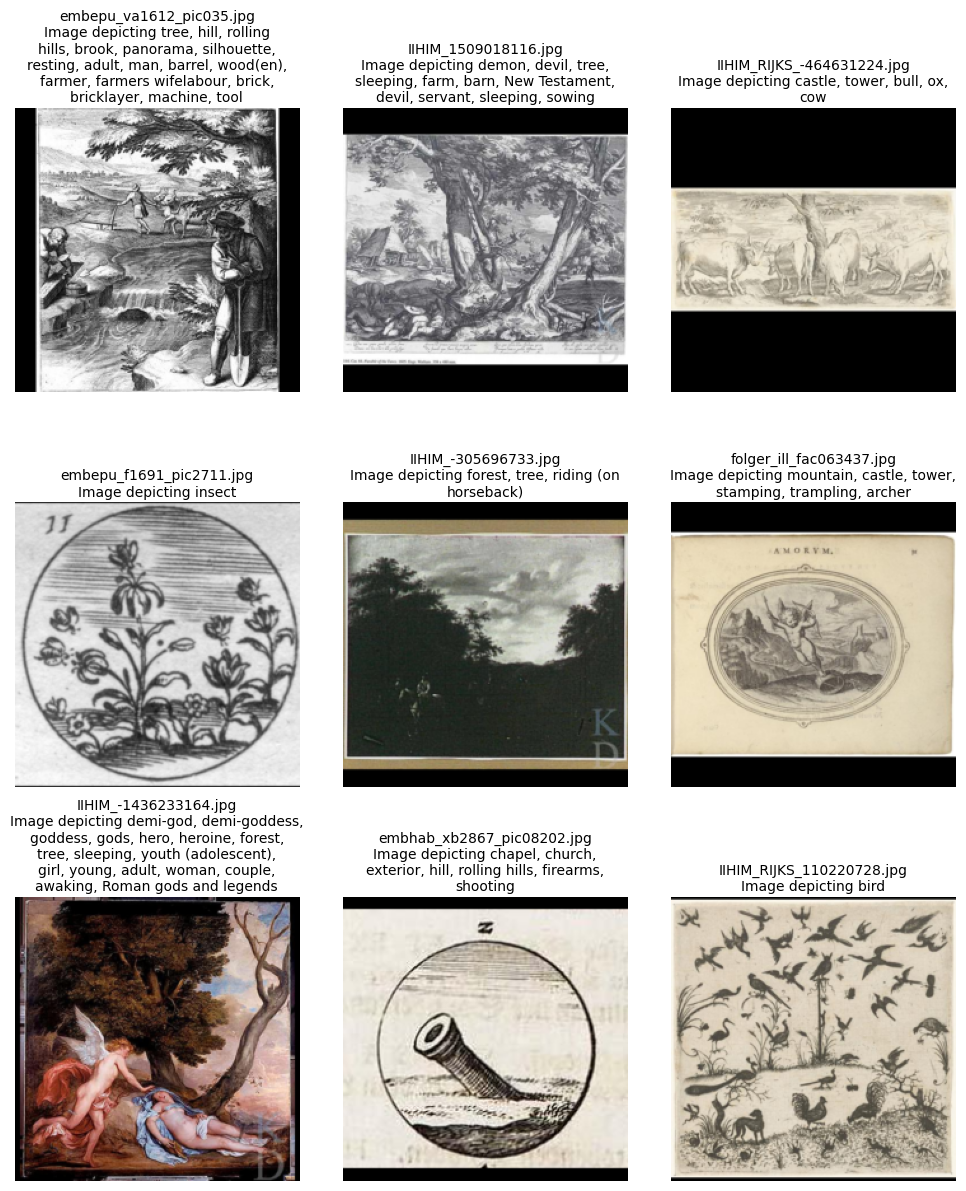

In [16]:
# Define the number of rows and columns in the preview table
num_rows = 3
num_cols = 3
num_images = num_rows * num_cols

# Shuffle the indices of the images and captions from the full dataset
indices = list(range(len(image_paths)))
#random.shuffle(indices)

# Load the images and captions for the preview and results tables
images = []
indx = []
for i, index in enumerate(indices[:num_images]):
    image = Image.open(image_paths[index]).convert("RGB")
    #print('Image path: ', image_paths[index])
    images.append(image)
    indx.append(index)
    if i == num_images - 1:
        break

# Create lists of captions, filenames, groundtruth, and classnumber of the set of images
captions = [image_captions[index] for index in indices[:num_images]]
filenames = [image_filenames[index] for index in indices[:num_images]]
#groundtruth = [ground_truth[index] for index in indices[:num_images]]
#classnumber = [class_number[index] for index in indices[:num_images]]

# Preprocess the images with the torchvision transform
preprocessed_images = torch.stack([preprocess_preview(image) for image in images])

# Create the preview table
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))
for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(preprocessed_images[i].permute(1, 2, 0))
    ax.axis("off")
    
    # Add the caption as the title
    longtitle = '\n'.join(textwrap.wrap(captions[i], width=40))
    filename = filenames[i]
    title = ax.set_title(filename + "\n" + longtitle, fontsize=10, clip_on=True, wrap=True)
    title.set_position([.5, .9])

# Adjust the spacing between the subplots
fig.subplots_adjust(hspace=0.5)

# Show the preview table
plt.tight_layout()
plt.show()

## Fine-tuning parameters

In [28]:
# Finetuning parameters
LR=5e-5 
EPOCHS = 20
num_batches = len(data_loader)
weight_decay=0.2

freeze_encoder = False # Set to False for end-to-end fine-tuning; Set to True to fine-tune the linear classifier only

SAVE_MODEL = 'CLIP-finetune/models/' # Specify path to save fine-tuned model

In [18]:
# Define optimizer and loss function
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=weight_decay)
loss_fn = torch.nn.CrossEntropyLoss()

In [19]:
devices = list(range(torch.cuda.device_count()))
print('Using devices', devices)
print('Torch CUDA device count: ', torch.cuda.device_count())

print(model.train())

Using devices [0]
Torch CUDA device count:  1
CLIP(
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
     

## Define Linear Classifier Class

In [20]:
# Linear Classifier (final classification layer)
class ClassificationHead(torch.nn.Linear):
    def __init__(self, normalize, weights, biases=None):
        output_size, input_size = weights.shape
        super().__init__(input_size, output_size)
        
        if weights is not None:
            self.weight = nn.Parameter(weights.clone())
        #else:
            # Initialise with default weights
            #self.weight = nn.Parameter(torch.randn(output_dim, input_dim))

        if biases is not None:
            self.bias = nn.Parameter(biases.clone())
        else:
            # Initialize with zeros
            self.bias = nn.Parameter(torch.zeros_like(self.bias))

        self.normalize = normalize

    def forward(self, inputs):
        if self.normalize:
            inputs = inputs / inputs.norm(dim=-1, keepdim=True)
        return super().forward(inputs)

In [21]:
from tqdm.notebook import tqdm
import time

In [22]:
# Get zeroshot weights from loaded model

def get_zeroshot_classifier():
    model.eval()
    model.to(device)
    
    print('Getting zeroshot weights.')

    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(openai_classnames):
            texts = []
            for t in openai_imagenet_template:
                texts.append(t(classname))
            texts = tokenizer(texts).to(device) # tokenize
            embeddings = model.encode_text(texts).float() # embed with text encoder
            embeddings = embeddings.mean(dim=0, keepdim=True)
            embeddings /= embeddings.norm()

            zeroshot_weights.append(embeddings)

        zeroshot_weights = torch.stack(zeroshot_weights, dim=0).to(device)
        zeroshot_weights = torch.transpose(zeroshot_weights, 0, 2)

        logit_scale = model.logit_scale
        
        zeroshot_weights *= logit_scale.exp()

        zeroshot_weights = zeroshot_weights.squeeze().float()
        zeroshot_weights = torch.transpose(zeroshot_weights, 0, 1)

    classification_head = ClassificationHead(normalize=True, weights=zeroshot_weights)

    return classification_head

classification_head = get_zeroshot_classifier()
classification_head

Getting zeroshot weights.


  0%|          | 0/1000 [00:00<?, ?it/s]

ClassificationHead(in_features=512, out_features=1000, bias=True)

# Fine-Tuning OpenCLIP

In [29]:
if freeze_encoder == True:
    print('Fine-tuning a linear classifier')
    for epoch in range(EPOCHS):
        #print(f"Epoch {epoch + 1}/{EPOCHS}")
        classification_head.train()

        # Create the progress bar
        data_loader_iter = tqdm(data_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=True, dynamic_ncols=False)
        
        for i, batch in enumerate(data_loader_iter):
            start_time = time.time()
            
            #step = i + epoch * num_batches
            #print('Step', step)
            
            optimizer.zero_grad()
            image_prep, caption_prep = batch
            ## TODO: input_key = 'features' instead of images!
            #print(images.shape)
            #print(captions.shape)
            images = image_prep.to(device)
            captions = caption_prep.to(device)
            data_time = time.time() - start_time
    
            outputs = model(images, captions)
            logits_per_image = outputs[0]
            logits_per_caption = outputs[1]
            #print('Logits per image: ', logits_per_image.shape)
            #print('Logits per caption: ', logits_per_caption.shape)
    
            ground_truth = torch.arange(len(images),dtype=torch.long,device=device)

            loss = (loss_fn(logits_per_image,ground_truth) + loss_fn(logits_per_caption,ground_truth))/2
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(params, 1.0)
            
            optimizer.step()
            batch_time = time.time() - start_time

            if i % 100 == 0:
                percent_complete = 100 * i / len(data_loader)
                print(
                    f"Loss: {loss.item():.6f}\tData (t) {data_time:.3f}\tBatch (t) {batch_time:.3f}", flush=True
                )

        
else:  # Fine-tuning the full model
    print('Fine-tuning end-to-end')
    model = model.cuda()
    devices = list(range(torch.cuda.device_count()))
    print('Using devices', devices)
    model = torch.nn.DataParallel(model, device_ids=devices)
    
    for epoch in range(EPOCHS):
        #print(f"Epoch {epoch + 1}/{EPOCHS}")
        model.train()

        # Create the progress bar
        data_loader_iter = tqdm(data_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=True, dynamic_ncols=False)
        
        for i, batch in enumerate(data_loader_iter):
            start_time = time.time()
            
            optimizer.zero_grad()
            image_prep, caption_prep = batch
            #print(images.shape)
            #print(captions.shape)
            images = image_prep.to(device)
            captions = caption_prep.to(device)
            data_time = time.time() - start_time
    
            outputs = model(images, captions)
            logits_per_image = outputs[0]
            logits_per_caption = outputs[1]
            #print('Logits per image: ', logits_per_image.shape)
            #print('Logits per caption: ', logits_per_caption.shape)

            ground_truth = torch.arange(len(images),dtype=torch.long,device=device)

            loss = (loss_fn(logits_per_image,ground_truth) + loss_fn(logits_per_caption,ground_truth))/2
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(params, 1.0)
            
            optimizer.step()
            batch_time = time.time() - start_time

            if i % 100 == 0:
                percent_complete = 100 * i / len(data_loader)
                print(
                    f"Loss: {loss.item():.6f}\tData (t) {data_time:.3f}\tBatch (t) {batch_time:.3f}", flush=True
                )


Fine-tuning end-to-end
Using devices [0]


Epoch 0/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.306871	Data (t) 0.018	Batch (t) 0.100


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.336124	Data (t) 0.002	Batch (t) 0.075


Epoch 2/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.300583	Data (t) 0.003	Batch (t) 0.074


Epoch 3/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.297122	Data (t) 0.003	Batch (t) 0.073


Epoch 4/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.292892	Data (t) 0.002	Batch (t) 0.074


Epoch 5/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.296040	Data (t) 0.002	Batch (t) 0.072


Epoch 6/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.324530	Data (t) 0.002	Batch (t) 0.069


Epoch 7/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.315709	Data (t) 0.002	Batch (t) 0.075


Epoch 8/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.306586	Data (t) 0.002	Batch (t) 0.073


Epoch 9/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.295738	Data (t) 0.002	Batch (t) 0.069


Epoch 10/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.326091	Data (t) 0.002	Batch (t) 0.073


Epoch 11/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.335464	Data (t) 0.002	Batch (t) 0.074


Epoch 12/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.290041	Data (t) 0.002	Batch (t) 0.075


Epoch 13/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.285919	Data (t) 0.002	Batch (t) 0.068


Epoch 14/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.306745	Data (t) 0.002	Batch (t) 0.078


Epoch 15/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.285522	Data (t) 0.002	Batch (t) 0.079


Epoch 16/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.280200	Data (t) 0.002	Batch (t) 0.070


Epoch 17/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.313850	Data (t) 0.002	Batch (t) 0.074


Epoch 18/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.300713	Data (t) 0.002	Batch (t) 0.074


Epoch 19/20:   0%|          | 0/20 [00:00<?, ?it/s]

Loss: 5.341923	Data (t) 0.002	Batch (t) 0.068


In [24]:
# Check input from data loader: print the first 5 samples

for i in range(5):  
    image_paths, image_captions = dataset[i]
    print(f"Sample {i + 1} - Image Shape: {image_prep.shape}, Caption: {caption_prep.shape}")

Sample 1 - Image Shape: torch.Size([10, 3, 224, 224]), Caption: torch.Size([10, 77])
Sample 2 - Image Shape: torch.Size([10, 3, 224, 224]), Caption: torch.Size([10, 77])
Sample 3 - Image Shape: torch.Size([10, 3, 224, 224]), Caption: torch.Size([10, 77])
Sample 4 - Image Shape: torch.Size([10, 3, 224, 224]), Caption: torch.Size([10, 77])
Sample 5 - Image Shape: torch.Size([10, 3, 224, 224]), Caption: torch.Size([10, 77])


In [25]:
# Check batch size from data loader

for i, batch in enumerate(data_loader):
    image_prep, caption_prep = batch
    print(f"Batch {i + 1} - Batch Size: {image_prep.size(0)}")

Batch 1 - Batch Size: 10
Batch 2 - Batch Size: 10
Batch 3 - Batch Size: 10
Batch 4 - Batch Size: 10
Batch 5 - Batch Size: 10
Batch 6 - Batch Size: 10
Batch 7 - Batch Size: 10
Batch 8 - Batch Size: 10
Batch 9 - Batch Size: 10
Batch 10 - Batch Size: 10
Batch 11 - Batch Size: 10
Batch 12 - Batch Size: 10
Batch 13 - Batch Size: 10
Batch 14 - Batch Size: 10
Batch 15 - Batch Size: 10
Batch 16 - Batch Size: 10
Batch 17 - Batch Size: 10
Batch 18 - Batch Size: 10
Batch 19 - Batch Size: 10
Batch 20 - Batch Size: 10


In [30]:
# Save the fine-tuned model

os.makedirs(SAVE_MODEL, exist_ok=True)

if freeze_encoder == True:
    print('Saving model to ', SAVE_MODEL, f"fine_tuned_clip_linear_checkpoint_{epoch+1}.pt")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }, os.path.join(SAVE_MODEL, f"fine_tuned_clip_linear_checkpoint_{epoch+1}.pt"))
    
else:
    print('Saving model to ', SAVE_MODEL, f"fine_tuned_clip_full_checkpoint_{epoch+1}.pt")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        }, os.path.join(SAVE_MODEL, f"fine_tuned_clip_full_checkpoint_{epoch+1}.pt"))


Saving model to  CLIP-finetune/models/ fine_tuned_clip_full_checkpoint_20.pt


In [27]:
# Access the innermost model (the one wrapped by multiple DataParallel)
inner_model = model

print(inner_model.visual(images).shape)
print(inner_model.transformer(inner_model.visual(images)).shape)
print(inner_model.token_embedding(captions).shape)

torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 77, 512])
